In [3]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torchvision.transforms as transforms
import torchvision.models as models

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)


Device: cuda


In [4]:
import tarfile

# Path to your tar.xz file inside Kaggle input folder
tar_path = '/kaggle/input/mv-tec/mvtec_anomaly_detection.tar.xz'  # adjust if needed
extract_path = '/kaggle/working/mvtec_anomaly_detection'  # we'll extract here

# Create the output directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the tar.xz file
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_path)

print(f'Files have been extracted to {extract_path}')

# List the top-level directories/files in the extracted folder
print("Top-level directories after extraction:", os.listdir(extract_path))


Files have been extracted to /kaggle/working/mvtec_anomaly_detection
Top-level directories after extraction: ['tile', 'hazelnut', 'cable', 'grid', 'transistor', 'toothbrush', 'wood', 'leather', 'zipper', 'capsule', 'pill', 'metal_nut', 'screw', 'bottle', 'license.txt', 'readme.txt', 'carpet']


In [5]:
data_dir = extract_path

# Display a sample image from the dataset
categories = os.listdir(data_dir)
for category in categories:
    path = os.path.join(data_dir, category)
    if not os.path.isdir(path):
        continue

    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_array = cv2.imread(img_path)

        if img_array is None:
            print(f"Failed to load image: {img_path}")
            continue

        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.title(f"Category: {category}, Image: {img}")
        plt.axis('off')
        plt.show()
        break
    break


Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/train
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/test
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/license.txt
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/readme.txt
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/ground_truth


In [6]:
# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = []

        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                self._add_category_images(category_path, category)

    def _add_category_images(self, category_path, category):
        # Normal images (label 0)
        normal_dir = os.path.join(category_path, 'train', 'good')
        if os.path.isdir(normal_dir):
            for img_name in os.listdir(normal_dir):
                img_path = os.path.join(normal_dir, img_name)
                self.images.append(img_path)
                self.labels.append(0)  # 0 for normal
                self.categories.append(category)

        # Anomalous images (label 1)
        test_dir = os.path.join(category_path, 'test')
        if os.path.isdir(test_dir):
            for condition in os.listdir(test_dir):
                if condition != 'good':
                    condition_dir = os.path.join(test_dir, condition)
                    if os.path.isdir(condition_dir):
                        for img_name in os.listdir(condition_dir):
                            img_path = os.path.join(condition_dir, img_name)
                            self.images.append(img_path)
                            self.labels.append(1)  # 1 for anomaly
                            self.categories.append(category)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx], self.categories[idx]

# Create the full dataset
full_dataset = MVTecDataset(data_dir, transform=transform)

print(f"Total images in dataset: {len(full_dataset)}")


Total images in dataset: 4887


In [7]:
train_indices, val_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    stratify=full_dataset.labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


Training samples: 3909
Validation samples: 978


In [8]:
# resnet18

class AnomalyDetectionModel(nn.Module):
    def __init__(self):
        super(AnomalyDetectionModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)  # binary classification

    def forward(self, x):
        return self.model(x)

model = AnomalyDetectionModel().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Calculate class weights (balanced)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(full_dataset.labels),
    y=full_dataset.labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

#  weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)


In [10]:
# train

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_accuracy = 100.0 * correct / total
    avg_train_loss = train_loss / len(train_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
            
            # For ROC
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs[:, 1].cpu().numpy())  # score for anomaly class
    
    val_accuracy = 100.0 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)
    
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


Epoch [1/100], Loss: 0.5838, Accuracy: 67.82%
Validation Loss: 0.4956, Validation Accuracy: 73.01%
Epoch [2/100], Loss: 0.4490, Accuracy: 77.13%
Validation Loss: 0.4058, Validation Accuracy: 77.51%
Epoch [3/100], Loss: 0.4027, Accuracy: 80.92%
Validation Loss: 0.3367, Validation Accuracy: 84.46%
Epoch [4/100], Loss: 0.3694, Accuracy: 82.48%
Validation Loss: 0.3560, Validation Accuracy: 84.56%
Epoch [5/100], Loss: 0.3504, Accuracy: 83.58%
Validation Loss: 0.3038, Validation Accuracy: 83.64%
Epoch [6/100], Loss: 0.3264, Accuracy: 85.19%
Validation Loss: 0.3384, Validation Accuracy: 85.38%
Epoch [7/100], Loss: 0.2883, Accuracy: 87.06%
Validation Loss: 0.3473, Validation Accuracy: 89.57%
Epoch [8/100], Loss: 0.2611, Accuracy: 87.85%
Validation Loss: 0.3175, Validation Accuracy: 84.76%
Epoch [9/100], Loss: 0.2520, Accuracy: 89.20%
Validation Loss: 0.2951, Validation Accuracy: 89.57%
Epoch [10/100], Loss: 0.2555, Accuracy: 89.95%
Validation Loss: 0.2618, Validation Accuracy: 88.04%
Epoch [11

In [11]:
# Save to the working directory
model_save_path = '/kaggle/working/cnn_anomaly_detection.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to /kaggle/working/cnn_anomaly_detection.pth


In [12]:
#ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [13]:
import random

def inspect_dataset(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))

    for i, idx in enumerate(indices):
        image, label, category = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        # De-normalize
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        axes[i].imshow(image.astype(np.uint8))
        axes[i].set_title(f'Label: {label}\nCategory: {category}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Inspect a random sample of images from the full dataset
inspect_dataset(full_dataset, num_samples=5)


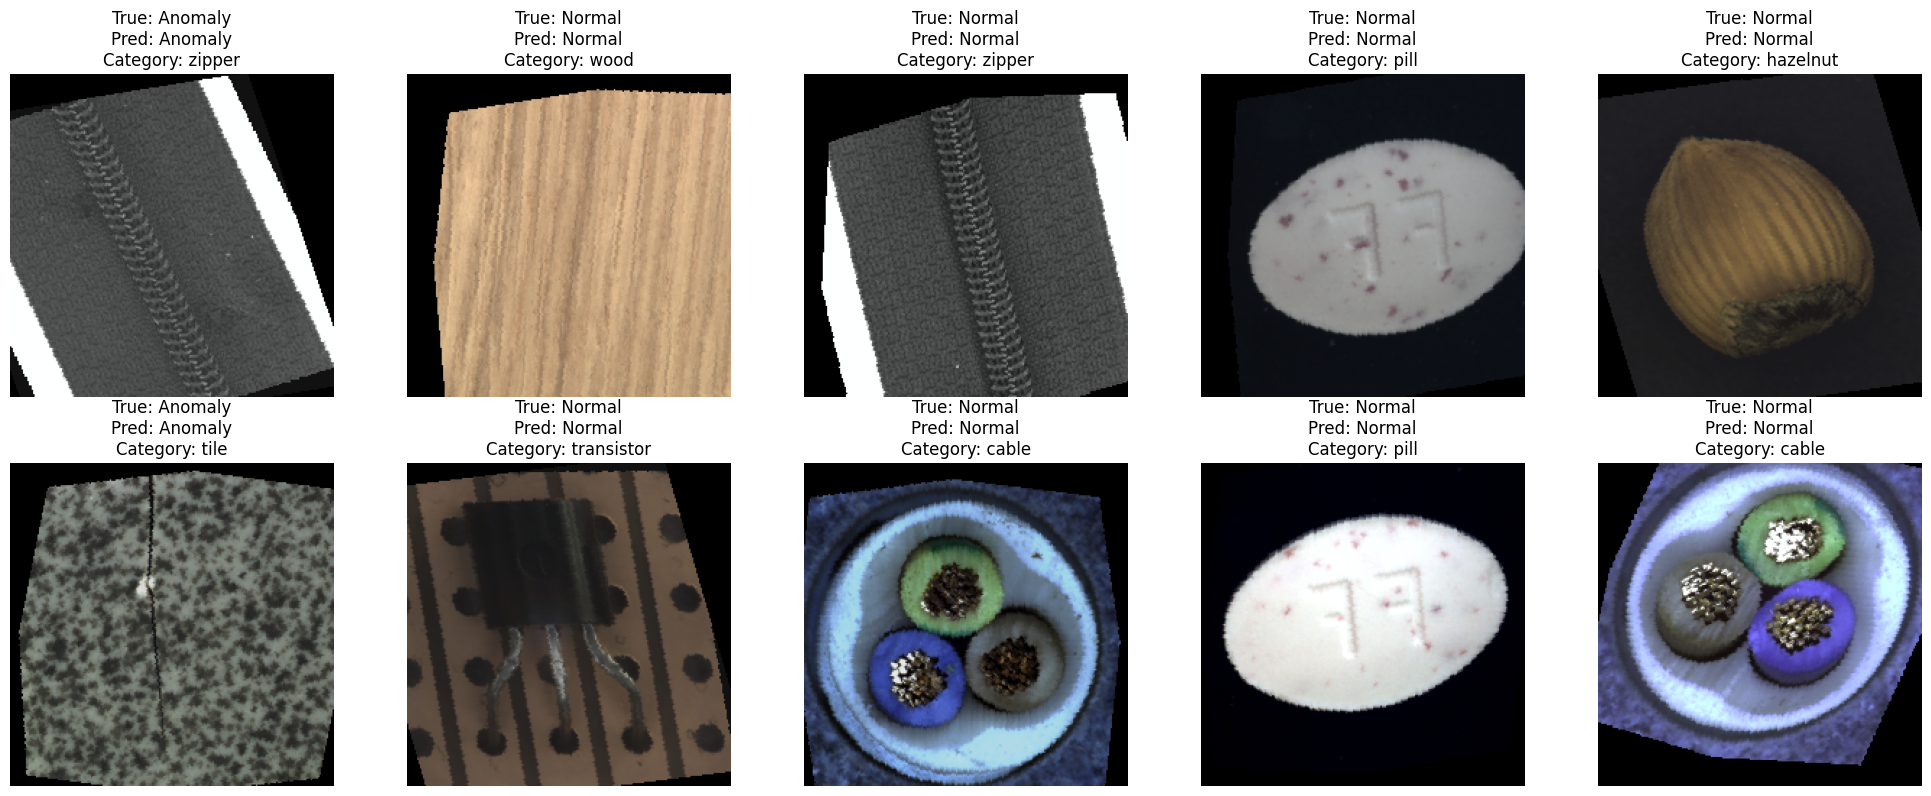

In [14]:
def visualize_correctly_classified(model, val_loader, num_images=10):
    model.eval()
    correctly_classified = []
    
    with torch.no_grad():
        for images, labels, categories in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            for i in range(len(images)):
                if predicted[i] == labels[i]:
                    # Save CPU version for visualization
                    correctly_classified.append((
                        images[i].cpu(),
                        labels[i].cpu(),
                        predicted[i].cpu(),
                        categories[i]
                    ))
                if len(correctly_classified) >= num_images:
                    break
            if len(correctly_classified) >= num_images:
                break

    fig, axes = plt.subplots(2, (num_images+1)//2, figsize=(20, 8))
    axes = axes.flatten() if num_images > 1 else [axes]

    for i, (image, true_label, pred_label, category) in enumerate(correctly_classified[:num_images]):
        image = image.permute(1, 2, 0).numpy()
        # De-normalize
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        
        ax = axes[i]
        ax.imshow(image.astype(np.uint8))
        ax.set_title(
            f"True: {'Normal' if true_label == 0 else 'Anomaly'}\n"
            f"Pred: {'Normal' if pred_label == 0 else 'Anomaly'}\n"
            f"Category: {category}"
        )
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_correctly_classified(model, val_loader, num_images=10)


In [15]:
category_performance = {}
model.eval()

with torch.no_grad():
    for images, labels, categories in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        for category, true_label, pred_label in zip(categories, labels, predicted):
            if category not in category_performance:
                category_performance[category] = {"correct": 0, "total": 0}
            category_performance[category]["total"] += 1
            if true_label == pred_label:
                category_performance[category]["correct"] += 1

for category, performance in category_performance.items():
    accuracy = performance["correct"] / performance["total"]
    print(f"Category: {category}, Accuracy: {accuracy:.4f}")


Category: zipper, Accuracy: 0.9859
Category: wood, Accuracy: 0.9831
Category: pill, Accuracy: 0.8974
Category: hazelnut, Accuracy: 0.9859
Category: tile, Accuracy: 0.9500
Category: transistor, Accuracy: 0.9818
Category: cable, Accuracy: 0.9178
Category: grid, Accuracy: 0.9846
Category: capsule, Accuracy: 0.9107
Category: carpet, Accuracy: 1.0000
Category: metal_nut, Accuracy: 0.9500
Category: leather, Accuracy: 1.0000
Category: toothbrush, Accuracy: 0.9333
Category: screw, Accuracy: 0.8788
Category: bottle, Accuracy: 1.0000


adding Checkpointing and Learning Rate Scheduling
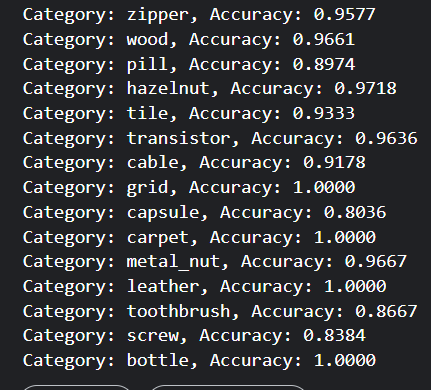

Device: cuda
Files have been extracted to /kaggle/working/mvtec_anomaly_detection
Top-level directories after extraction: ['tile', 'hazelnut', 'cable', 'grid', 'transistor', 'toothbrush', 'wood', 'leather', 'zipper', 'capsule', 'pill', 'metal_nut', 'screw', 'bottle', 'license.txt', 'readme.txt', 'carpet']
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/train
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/test
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/license.txt
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/readme.txt
Failed to load image: /kaggle/working/mvtec_anomaly_detection/tile/ground_truth
Total images in dataset: 4887
Training samples: 3909
Validation samples: 978


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/100], Loss: 0.5846, Accuracy: 67.56%
Validation Loss: 0.4960, Validation Accuracy: 71.98%
Checkpoint saved at epoch 1 with validation loss 0.4960
Epoch [2/100], Loss: 0.4465, Accuracy: 77.21%
Validation Loss: 0.3899, Validation Accuracy: 78.63%
Checkpoint saved at epoch 2 with validation loss 0.3899
Epoch [3/100], Loss: 0.4051, Accuracy: 80.61%
Validation Loss: 0.3457, Validation Accuracy: 86.91%
Checkpoint saved at epoch 3 with validation loss 0.3457
Epoch [4/100], Loss: 0.3772, Accuracy: 81.99%
Validation Loss: 0.3723, Validation Accuracy: 85.17%
Epoch [5/100], Loss: 0.3576, Accuracy: 83.29%
Validation Loss: 0.3124, Validation Accuracy: 82.72%
Checkpoint saved at epoch 5 with validation loss 0.3124
Epoch [6/100], Loss: 0.3192, Accuracy: 86.11%
Validation Loss: 0.3429, Validation Accuracy: 83.13%
Epoch [7/100], Loss: 0.3069, Accuracy: 86.54%
Validation Loss: 0.3114, Validation Accuracy: 89.26%
Checkpoint saved at epoch 7 with validation loss 0.3114
Epoch [8/100], Loss: 0.2618

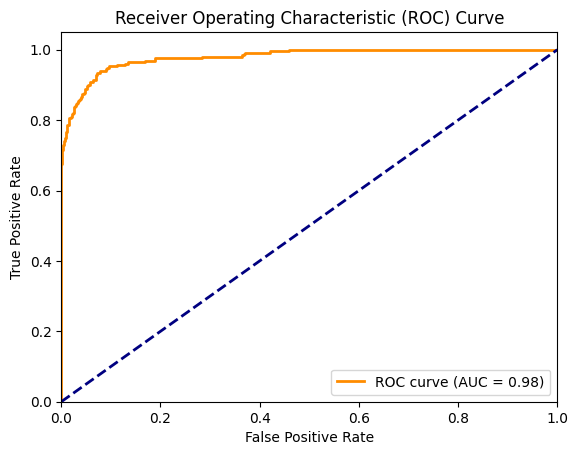

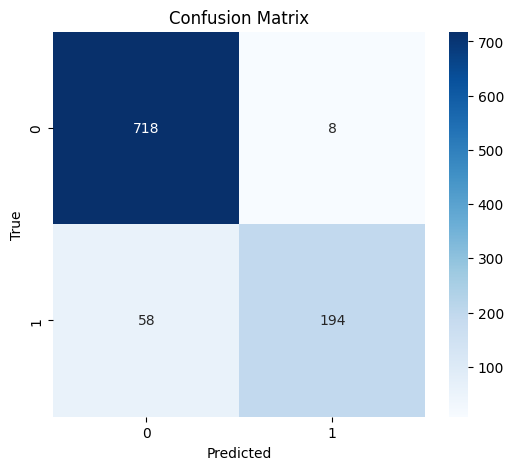

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       726
           1       0.96      0.77      0.85       252

    accuracy                           0.93       978
   macro avg       0.94      0.88      0.91       978
weighted avg       0.93      0.93      0.93       978



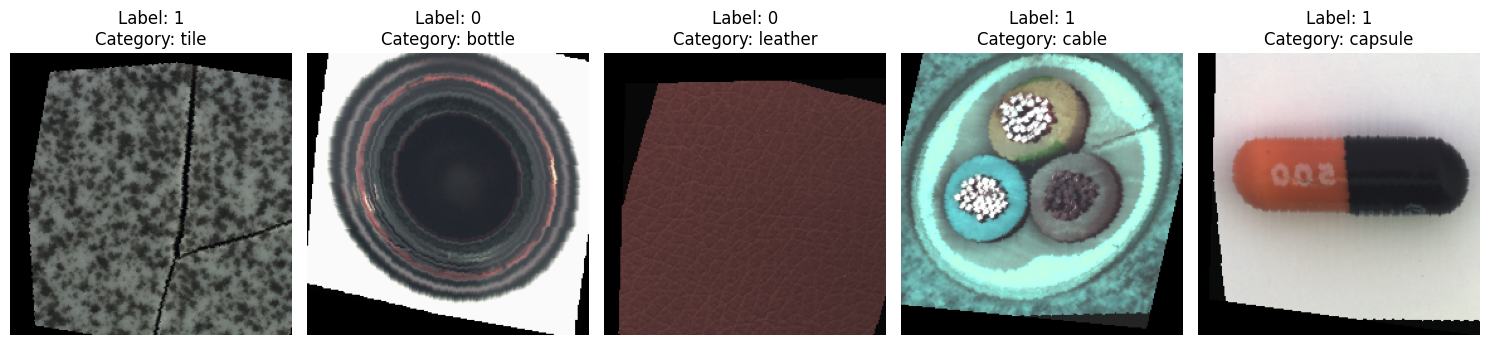

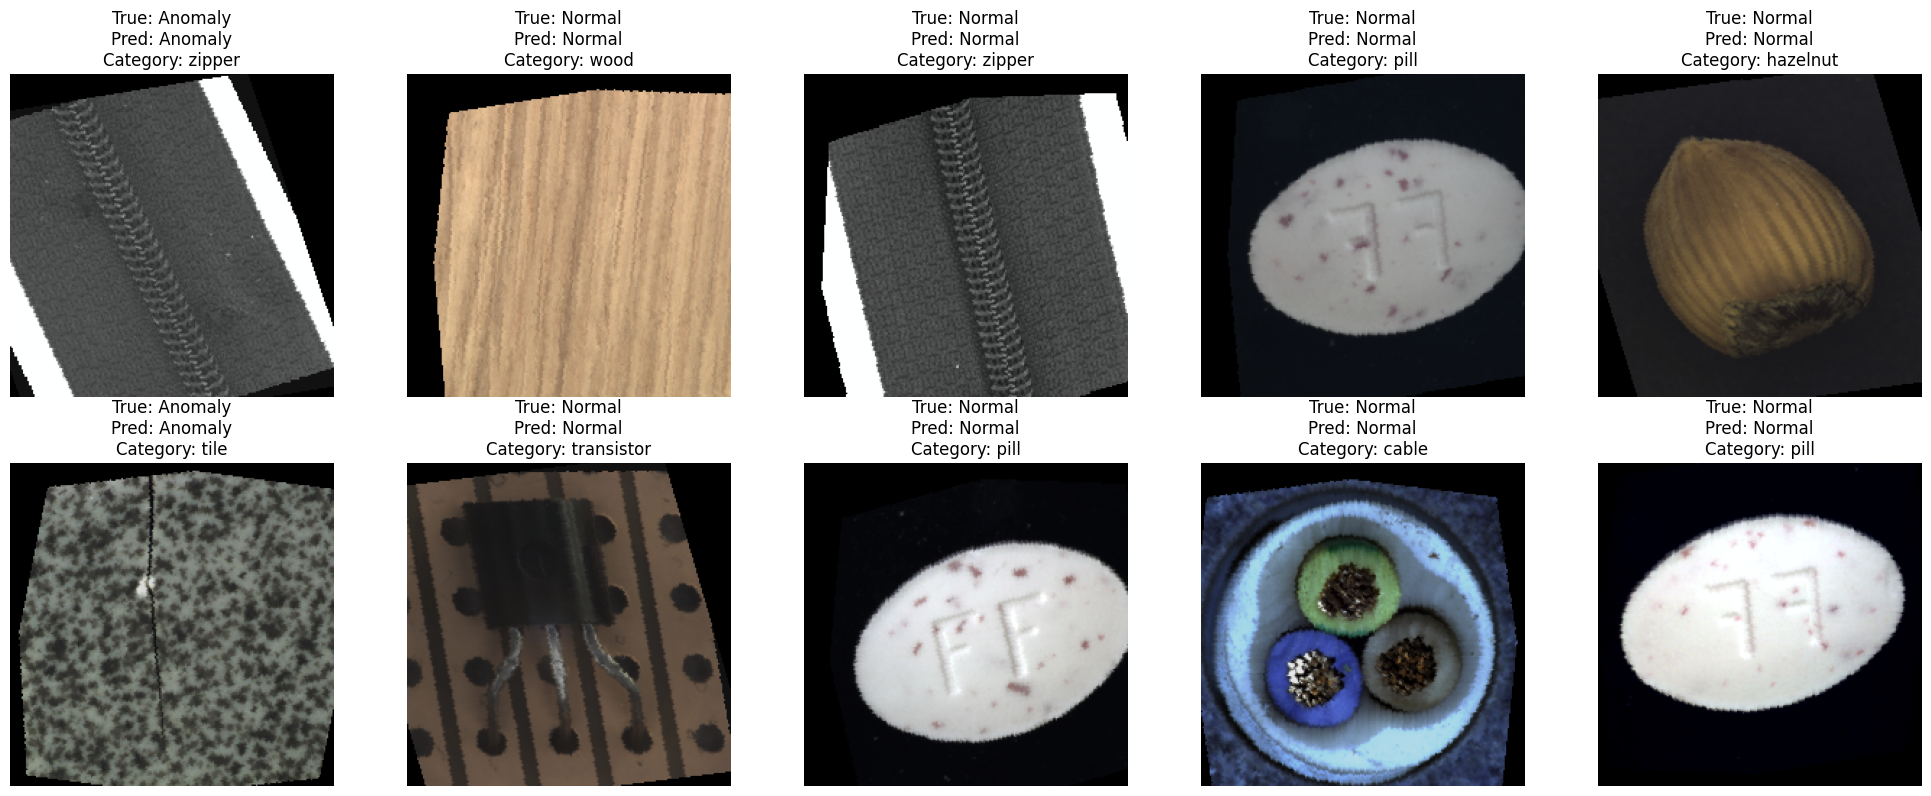

Category: zipper, Accuracy: 0.9577
Category: wood, Accuracy: 0.9661
Category: pill, Accuracy: 0.8974
Category: hazelnut, Accuracy: 0.9718
Category: tile, Accuracy: 0.9333
Category: transistor, Accuracy: 0.9636
Category: cable, Accuracy: 0.9178
Category: grid, Accuracy: 1.0000
Category: capsule, Accuracy: 0.8036
Category: carpet, Accuracy: 1.0000
Category: metal_nut, Accuracy: 0.9667
Category: leather, Accuracy: 1.0000
Category: toothbrush, Accuracy: 0.8667
Category: screw, Accuracy: 0.8384
Category: bottle, Accuracy: 1.0000


In [16]:
# Cell 1

import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torchvision.transforms as transforms
import torchvision.models as models

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)


# Cell 3

import tarfile

# Path to your tar.xz file inside Kaggle input folder
tar_path = '/kaggle/input/mv-tec/mvtec_anomaly_detection.tar.xz'  # adjust if needed
extract_path = '/kaggle/working/mvtec_anomaly_detection'  # we'll extract here

# Create the output directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the tar.xz file
with tarfile.open(tar_path, 'r') as tar:
    tar.extractall(path=extract_path)

print(f'Files have been extracted to {extract_path}')

# List the top-level directories/files in the extracted folder
print("Top-level directories after extraction:", os.listdir(extract_path))


# Cell 4

data_dir = extract_path

# Display a sample image from the dataset
categories = os.listdir(data_dir)
for category in categories:
    path = os.path.join(data_dir, category)
    if not os.path.isdir(path):
        continue

    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        img_array = cv2.imread(img_path)

        if img_array is None:
            print(f"Failed to load image: {img_path}")
            continue

        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.title(f"Category: {category}, Image: {img}")
        plt.axis('off')
        plt.show()
        break
    break


# Cell 5

# Define transforms
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

class MVTecDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []
        self.categories = []

        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                self._add_category_images(category_path, category)

    def _add_category_images(self, category_path, category):
        # Normal images (label 0)
        normal_dir = os.path.join(category_path, 'train', 'good')
        if os.path.isdir(normal_dir):
            for img_name in os.listdir(normal_dir):
                img_path = os.path.join(normal_dir, img_name)
                self.images.append(img_path)
                self.labels.append(0)  # 0 for normal
                self.categories.append(category)

        # Anomalous images (label 1)
        test_dir = os.path.join(category_path, 'test')
        if os.path.isdir(test_dir):
            for condition in os.listdir(test_dir):
                if condition != 'good':
                    condition_dir = os.path.join(test_dir, condition)
                    if os.path.isdir(condition_dir):
                        for img_name in os.listdir(condition_dir):
                            img_path = os.path.join(condition_dir, img_name)
                            self.images.append(img_path)
                            self.labels.append(1)  # 1 for anomaly
                            self.categories.append(category)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, self.labels[idx], self.categories[idx]

# Create the full dataset
full_dataset = MVTecDataset(data_dir, transform=transform)

print(f"Total images in dataset: {len(full_dataset)}")


# Cell 6

train_indices, val_indices = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    stratify=full_dataset.labels,
    random_state=42
)

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
val_dataset = torch.utils.data.Subset(full_dataset, val_indices)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print("Training samples:", len(train_dataset))
print("Validation samples:", len(val_dataset))


# Cell 7

class AnomalyDetectionModel(nn.Module):
    def __init__(self):
        super(AnomalyDetectionModel, self).__init__()
        self.model = models.resnet18(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 2)  # binary classification

    def forward(self, x):
        return self.model(x)

model = AnomalyDetectionModel().to(device)

# Cell 8

# Calculate class weights (balanced)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(full_dataset.labels),
    y=full_dataset.labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define the weighted loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Use Adam optimizer with a small learning rate
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# --- Added Learning Rate Scheduler ---
# Reduce LR by a factor of 0.1 every 10 epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


# Cell 9

num_epochs = 100
best_val_loss = float('inf')  # Initialize best validation loss

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels, _ in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_accuracy = 100.0 * correct / total
    avg_train_loss = train_loss / len(train_loader)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy:.2f}%')
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    y_true = []
    y_scores = []
    
    with torch.no_grad():
        for images, labels, _ in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()
            
            # For ROC
            y_true.extend(labels.cpu().numpy())
            y_scores.extend(outputs[:, 1].cpu().numpy())  # score for anomaly class
    
    val_accuracy = 100.0 * correct_val / total_val
    avg_val_loss = val_loss / len(val_loader)
    
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    
    # --- Learning Rate Scheduler Step ---
    scheduler.step()
    
    # --- Checkpointing ---
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': avg_val_loss,
        }
        checkpoint_path = '/kaggle/working/best_model_checkpoint.pth'
        torch.save(checkpoint, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1} with validation loss {avg_val_loss:.4f}")


# Cell 10

# Save to the working directory
model_save_path = '/kaggle/working/cnn_anomaly_detection.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


# Cell 11

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Confusion matrix
y_pred = (np.array(y_scores) > 0.5).astype(int)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred))


# Cell 12

import random

def inspect_dataset(dataset, num_samples=10):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))

    for i, idx in enumerate(indices):
        image, label, category = dataset[idx]
        image = image.permute(1, 2, 0).numpy()
        # De-normalize
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        axes[i].imshow(image.astype(np.uint8))
        axes[i].set_title(f'Label: {label}\nCategory: {category}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Inspect a random sample of images from the full dataset
inspect_dataset(full_dataset, num_samples=5)

# Cell 13

def visualize_correctly_classified(model, val_loader, num_images=10):
    model.eval()
    correctly_classified = []
    
    with torch.no_grad():
        for images, labels, categories in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = outputs.max(1)

            for i in range(len(images)):
                if predicted[i] == labels[i]:
                    # Save CPU version for visualization
                    correctly_classified.append((
                        images[i].cpu(),
                        labels[i].cpu(),
                        predicted[i].cpu(),
                        categories[i]
                    ))
                if len(correctly_classified) >= num_images:
                    break
            if len(correctly_classified) >= num_images:
                break

    fig, axes = plt.subplots(2, (num_images+1)//2, figsize=(20, 8))
    axes = axes.flatten() if num_images > 1 else [axes]

    for i, (image, true_label, pred_label, category) in enumerate(correctly_classified[:num_images]):
        image = image.permute(1, 2, 0).numpy()
        # De-normalize
        image = (image * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        
        ax = axes[i]
        ax.imshow(image.astype(np.uint8))
        ax.set_title(
            f"True: {'Normal' if true_label == 0 else 'Anomaly'}\n"
            f"Pred: {'Normal' if pred_label == 0 else 'Anomaly'}\n"
            f"Category: {category}"
        )
        ax.axis('off')

    plt.tight_layout()
    plt.show()

visualize_correctly_classified(model, val_loader, num_images=10)

# Cell 14

category_performance = {}
model.eval()

with torch.no_grad():
    for images, labels, categories in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)

        for category, true_label, pred_label in zip(categories, labels, predicted):
            if category not in category_performance:
                category_performance[category] = {"correct": 0, "total": 0}
            category_performance[category]["total"] += 1
            if true_label == pred_label:
                category_performance[category]["correct"] += 1

for category, performance in category_performance.items():
    accuracy = performance["correct"] / performance["total"]
    print(f"Category: {category}, Accuracy: {accuracy:.4f}")
